Simulating: 100%|██████████| 40/40 [00:18<00:00,  2.13it/s]


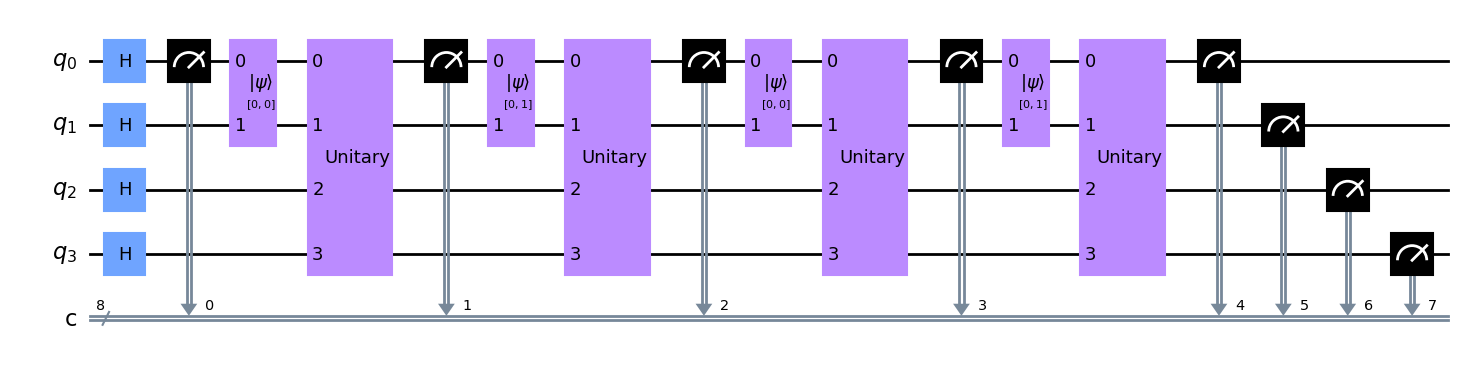

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import random_unitary
from qreservoirpy import QReservoir, Layers, utilities


def add_on(circ, timestep, operator, encoder):
    circ.measure(circ.qubits[0])
    circ.initialize(encoder[timestep], [0, 1])
    circ.unitary(operator, circ.qubits)
    return circ

res = QReservoir(qubits=4, layers=[
    Layers.H(),
    Layers.Timeseries(build_method=add_on),
    Layers.Measurement([0, 1, 2, 3])
], operator=random_unitary(2**4), encoder = {
    0: '00',
    1: '01',
    2: '10',
    3: '11'
}, analyze_function=lambda res: res[-4:], incrementally=True, M=5)

target = [0, 1, 1, 2] * 10
states = res.run(target, shots=10000)

res.circuit.draw('mpl')



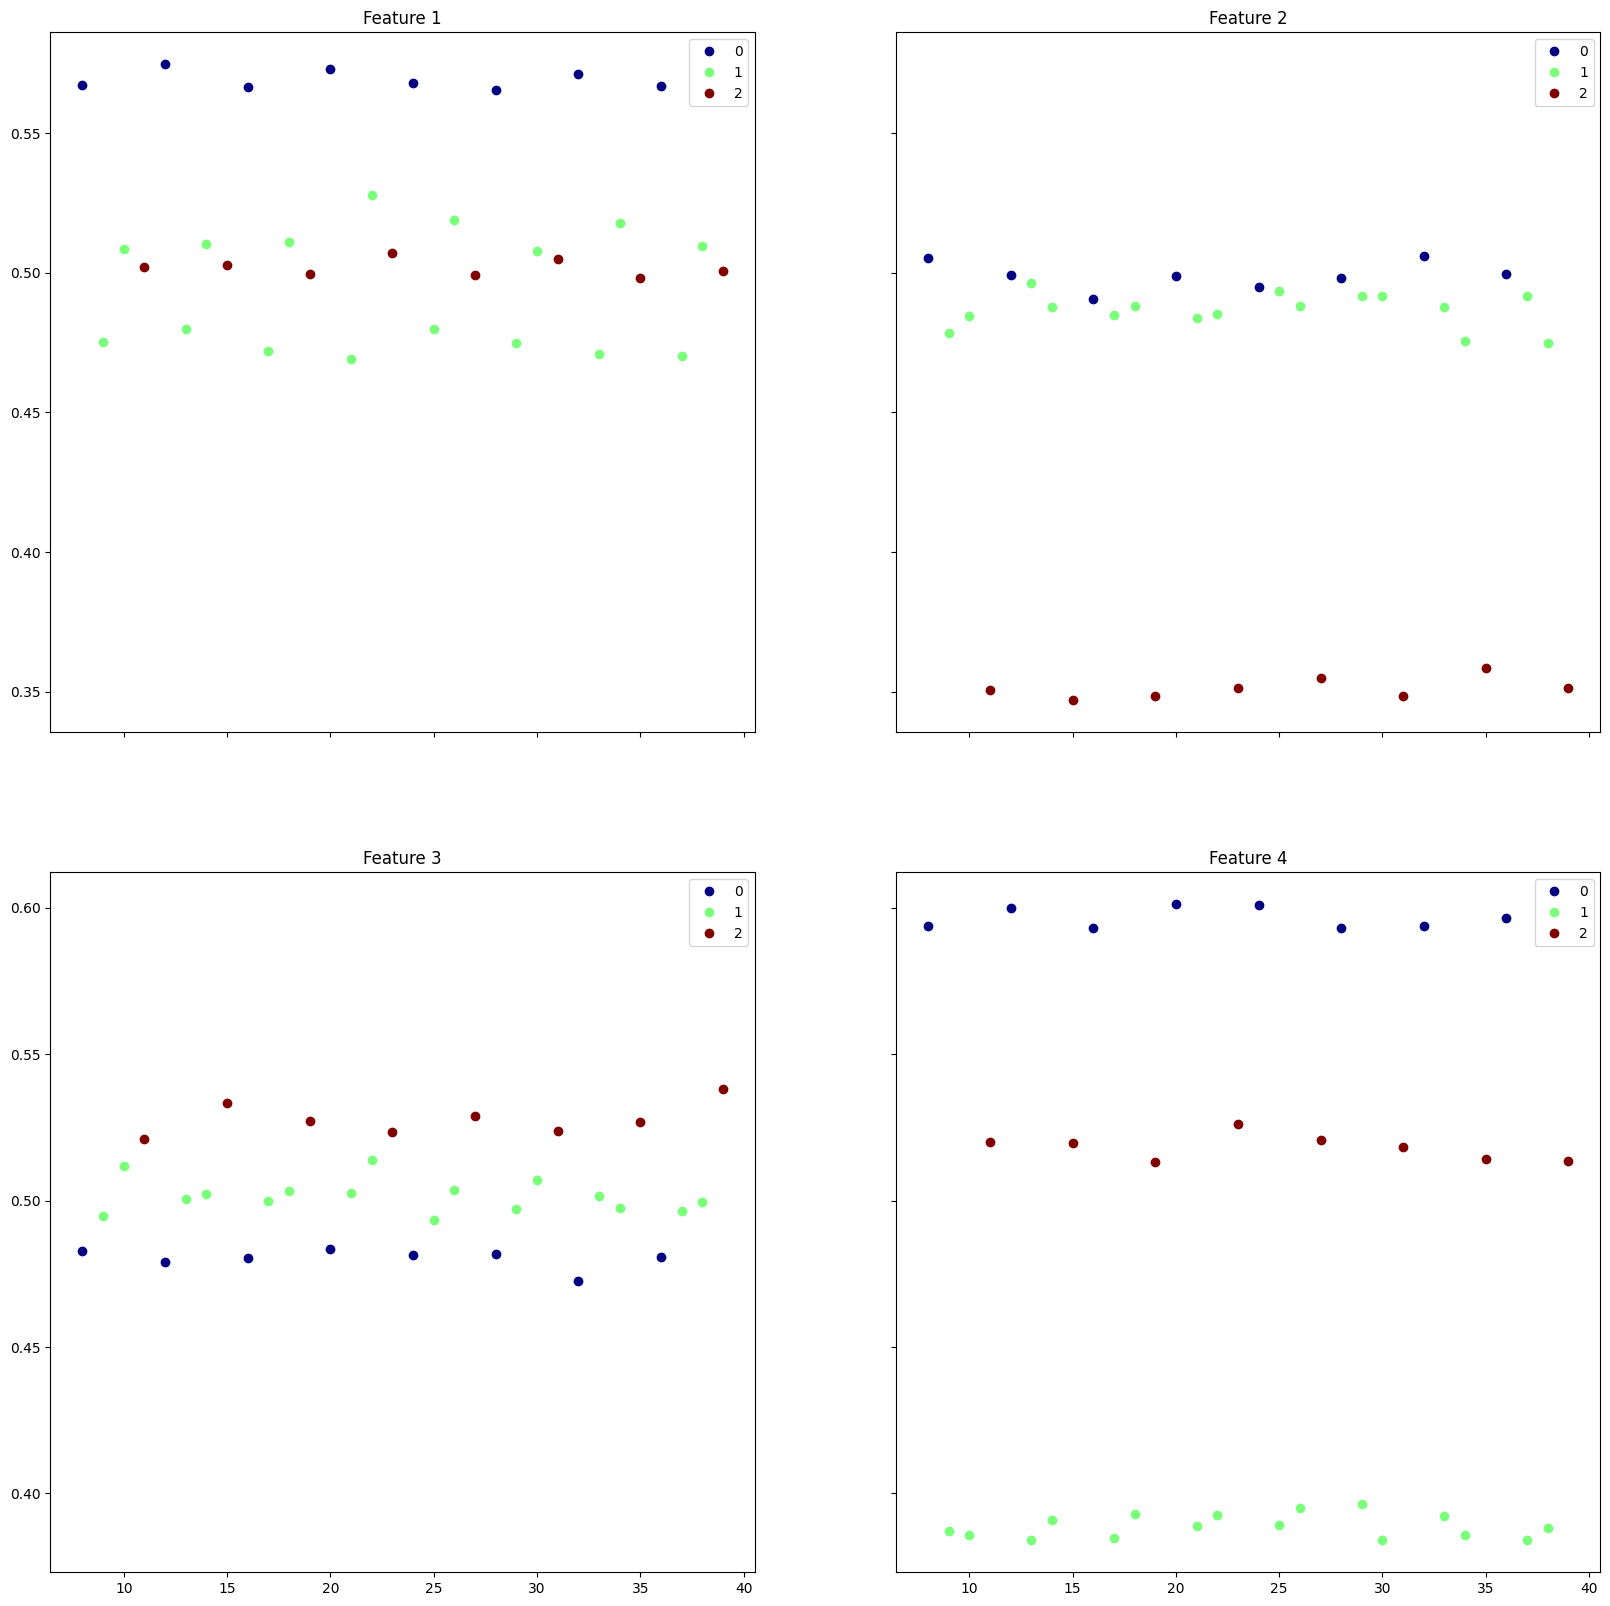

In [2]:
fig, axes = utilities.result_plotter(states, target, warmup=0.2)